[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bamirandab/nlp-disaster-tweets/blob/main/notebooks/EDA.ipynb)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from google.colab import files
files.upload() #upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bamirandab","key":"acf8e7fbd28901f7d9fc992f669fd7d0"}'}

In [5]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [6]:
!kaggle competitions download -c nlp-getting-started -p ../data

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 115MB/s]


# Exploratory Data Analysis - EDA

In [7]:
!pip install mapply

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76 kB 3.3 MB/s 
     |████████████████████████████████| 52 kB 1.1 MB/s 
     |████████████████████████████████| 115 kB 44.0 MB/s 


## Load Data

In [8]:
from zipfile import ZipFile
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import mapply

mapply.init(
    n_workers=-1,
    chunk_size=100,
    max_chunks_per_worker=8,
    progressbar=False
)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [9]:
path = os.path.join('../data/nlp-getting-started.zip')

with ZipFile(path, 'r') as zipObj:
#    # Extract all the contents of zip file in current directory
   zipObj.extractall('../data')

In [10]:
data_path = '../data/'
train_df = pd.read_csv(data_path + 'train.csv', encoding='utf-8')
test_df = pd.read_csv(data_path + 'test.csv', encoding='utf-8')

train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [11]:
def search_keywords(x, tweet):
  result = re.search('[{letter}]\w+'.format(letter=x),tweet)
  if result: 
    return True
  else:
    return False

nltk.download('stopwords')
stop_words = stopwords.words()

def clean_tweet(tweet):
  tweet_tokens = re.sub('\s+', ' ', tweet.lower()).split(' ')
  tweet_clean = ' '.join([word for word in tweet_tokens if not word in stop_words])
  return tweet_clean


def drop_word(x, tweet):
  return re.sub('[{letter}]\w+'.format(letter=x),'',tweet)

def drop_url(tweet):
  return re.sub(r'http\S+','',tweet)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
train_tweets = train_df["text"].mapply(lambda x: clean_tweet(x))
test_tweets = test_df["text"].mapply(lambda x: clean_tweet(x))
train_labels = train_df["target"]

In [13]:
from sklearn.metrics import confusion_matrix

In [14]:
hashtag = train_tweets.apply(lambda x: search_keywords('#',x))
mentions = train_tweets.apply(lambda x: search_keywords('@',x))
urls = train_tweets.apply(lambda x: search_keywords('https',x))

hashtag_test = test_tweets.apply(lambda x: search_keywords('#',x))
mentions_test = test_tweets.apply(lambda x: search_keywords('@',x))
urls_test = train_tweets.apply(lambda x: search_keywords('https',x))


print('comparative labels with tweets with hashtag')
print(confusion_matrix(train_labels,hashtag))

print('\n')

print('comparative labels with tweets with mentions')
print(confusion_matrix(train_labels,mentions))

print('\n')

print('comparative labels with tweets with urls')
print(confusion_matrix(train_labels,urls))



comparative labels with tweets with hashtag
[[3457  885]
 [2413  858]]


comparative labels with tweets with mentions
[[2999 1343]
 [2605  666]]


comparative labels with tweets with urls
[[  83 4259]
 [  11 3260]]


In [16]:
train_tweets_clean = train_tweets.mapply(lambda x: drop_url(drop_word('#',drop_word('@',x))))
test_tweets_clean = test_tweets.mapply(lambda x: drop_url(drop_word('#',drop_word('@',x))))

In [17]:
train_tweets_clean

0                             deeds reason  allah forgive
1                          forest fire ronge sask. canada
2       residents asked 'shelter place' notified offic...
3           13,000 receive  evacuation orders california 
4                        photo ruby  smoke  pours school 
                              ...                        
7608    giant cranes holding bridge collapse nearby ho...
7609      control wild fires california northern part ...
7610               m1.94 [01:04 utc]?5km volcano hawaii. 
7611    police investigating e-bike collided car portu...
7612    latest: homes razed northern california wildfi...
Name: text, Length: 7613, dtype: object

In [18]:
train_sentences = []
for i, tweet in enumerate(train_tweets_clean.to_list()):
  temp_sentencs = tweet
  if hashtag[i]:
    temp_sentencs += ' hashtag'
  
  if mentions[i]:
    temp_sentencs += ' mention'
  
  if urls[i]:
    temp_sentencs += ' URL'

  train_sentences.append(temp_sentencs)



test_sentences = []
for i, tweet in enumerate(test_tweets_clean.to_list()):
  temp_sentencs = tweet
  if hashtag_test[i]:
    temp_sentencs += ' hashtag'
  
  if mentions_test[i]:
    temp_sentencs += ' mention'

  if urls_test[i]:
    temp_sentencs += ' URL'

  
  
  test_sentences.append(temp_sentencs)

train_labels = train_labels.to_list()

In [19]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()


word cloud train data


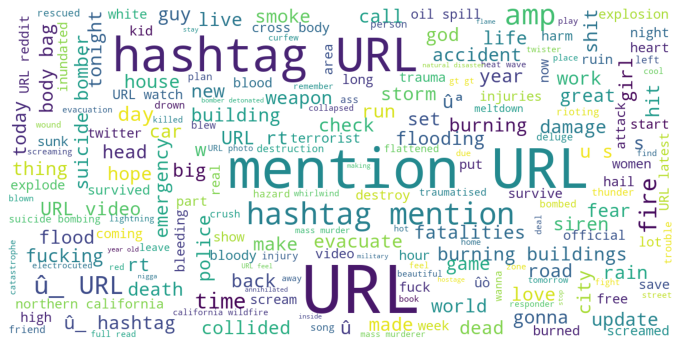


 word cloud test data


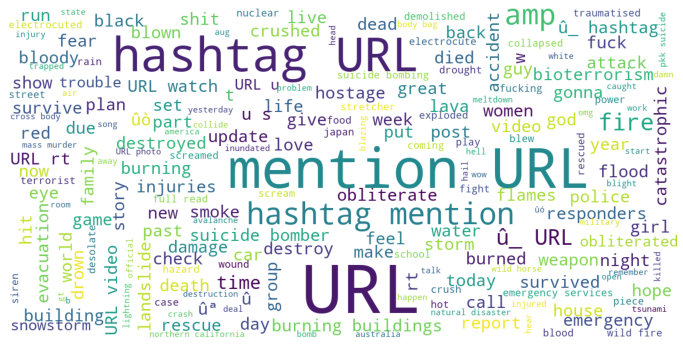

In [20]:
print('word cloud train data')
show_wordcloud(' '.join(train_sentences))

print('\n word cloud test data')
show_wordcloud(' '.join(test_sentences))